In [9]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [10]:
root_path = 'gdrive/My Drive/Colab Notebooks/ML/Task 2/'
path_to_data_train = "dstc8-train.txt"
path_to_data_val = "dstc8-val-candidates.txt"
path_to_data_test = "dstc8-test-candidates.txt"

In [11]:
# Code extended from the following source: https://www.tensorflow.org/tutorials/text/nmt_with_attention
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
tf.test.is_gpu_available()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import concurrent.futures
import collections
import unicodedata
import re
import numpy as np
import os
import io
import sys
import math
import time

In [12]:
#########################################
# RNN ENCODER-DECODER 
#########################################
#https://stackoverflow.com/questions/55490830/how-to-set-an-initial-state-for-a-bidirectional-lstm-layer-in-keras
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # tell LSTM you want to get the states, and sequences returned
        self.lstmb = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                                                        return_sequences=True,
                                                                        return_state=True,
                                                                        dropout=0.1,
                                                                        go_backwards= True))
        self.lstmb2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                                                        return_sequences=True,
                                                                        return_state=True,
                                                                        dropout=0.1,
                                                                        go_backwards= True))


    def call(self, x, hidden):
        x = self.embedding(x)
        # no need to pass [hidden, hidden], just pass it as is
        output, forward_h, forward_c, backward_h, backward_c = self.lstmb(x, initial_state=hidden)
        output, forward_h, forward_c, backward_h, backward_c = self.lstmb2(output, initial_state=[forward_h, forward_c, backward_h, backward_c])
        return output, forward_h, forward_c, backward_h, backward_c


    def initialize_hidden_state(self):
        # I stole this idea from iamlcc, so the credit is not mine.
        return [tf.zeros((self.batch_sz, self.enc_units)) for i in range(4)]

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstmb = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.dec_units,    
                                                                    return_sequences=True,
                                                                    return_state=True,
                                                                    dropout=0.1,
                                                                    go_backwards= True))
    self.lstmb2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.dec_units,
                                                                        return_sequences=True,
                                                                        return_state=True,
                                                                        dropout=0.1,
                                                                        go_backwards= True))


    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output, initial_state):
    x = self.embedding(x)

    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    
    x, h, c, b, b_c = self.lstmb(x, initial_state = initial_state)
    x, h, c, b, b_c = self.lstmb2(x, initial_state = [h, c, b, b_c])
    states = tf.concat([h, b], axis=1)
    output = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc(output)
    return x, states, attention_weights
    

In [13]:
#########################################
# TEXT PROCESSING
#########################################
root_path = 'gdrive/My Drive/Colab Notebooks/ML/Task 2/'
path_to_data_train = "dstc8-train.txt"
path_to_data_val = "dstc8-val-candidates.txt"
path_to_data_test = "dstc8-test-candidates.txt"

# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,Ã‚Â¿])", r" \1 ", w)
  w = re.sub(r'[" "]', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  #w = re.sub(r"[^a-zA-Z?.!,Ã‚Â¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  print(lines)

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines]
  print(word_pairs)
  return zip(*word_pairs)

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

def load_dataset(path):
  inp_lang, targ_lang = create_dataset(path)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

input_tensor_train, target_tensor_train, inp_lang, targ_lang = load_dataset(root_path + path_to_data_train)
max_length_targ, max_length_inp = target_tensor_train.shape[1], input_tensor_train.shape[1]
print(len(input_tensor_train), len(target_tensor_train))

def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

['domain=music <sod> can you find song s from $artist s ablum $album ?\ti found $count song from $artist s $album album . the song is $song name .', 'domain=music what s its genre ?\tthe genre is $genre .', 'domain=music that is great .\tdo you want to play the music now ?', 'domain=music sure .\tdo you want me to play $song name on $playback device .', 'domain=music please play it on the $playback device .\twould you like me to play $song name on the $playback device ?', 'domain=music no . please play it on the $playback device .\twould you like me to play $song name on the $playback device ?', 'domain=music yes , that is correct .\tstarted playing the song .', 'domain=music thank you . that is all i need .\thave a good day . <eod>', 'domain=music <sod> i want to listen to some songs from the album $album .\tdo you want to listen to $song name by $artist , from her album $album ?', 'domain=music what is the genre ?\tit is a $genre song .', 'domain=music that is good , please play the 

In [14]:
#########################################
# TRAINING
#########################################

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  acc = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden, forward_c, backward_h, backward_c = encoder(inp, enc_hidden) 

    encoder_state = [enc_hidden, forward_c, backward_h, backward_c]

    dec_hidden = tf.keras.layers.Concatenate()([forward_h, backward_h])

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]): #Shape is wrong?
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output, initial_state= encoder_state)
      loss += loss_function(targ[:, t], predictions)
      #acc += accuracy_function(targ[:, t], predictions)
      

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss, acc

def train_model(EPOCHS):
    loss_plot = []
    acc_plt = []
    for epoch in range(EPOCHS):
        start = time.time()

        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0
        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss, acc = train_step(inp, targ, enc_hidden) #Breaks here
            total_loss += batch_loss

            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))

        if (epoch + 1) == 25:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                            total_loss / steps_per_epoch))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
        loss_plot.append(total_loss/steps_per_epoch)
        plt.plot(loss_plot, 'r')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

In [15]:
#########################################
# EVALUATION
#########################################

def evaluate(sentence, candidate=None, id=None):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    inputs = []
    for word in sentence.split(' '):
        if word in inp_lang.word_index:
            inputs.append(inp_lang.word_index[word])

    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    value = 0

    hidden = [tf.zeros((1, units)) for i in range(4)]

    enc_out, forward_h, forward_c, backward_h, backward_c = encoder(inputs, hidden)

    encoder_state = [forward_h, forward_c, backward_h, backward_c]
    dec_hidden = tf.keras.layers.Concatenate()([forward_h, backward_h])
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    candidate_words = []
    if candidate != None:
        candidate = candidate + " <end>"
        for word in candidate.split(' '):
            if word in targ_lang.word_index:
                candidate_words.append(targ_lang.word_index[word])

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out, initial_state = encoder_state)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        if candidate == None:
            predicted_id = tf.argmax(predictions[0]).numpy()
        else:
            predicted_id = candidate_words[t]

        value += predictions[0][predicted_id].numpy()

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, value/t, id, sentence, attention_plot

        result += targ_lang.index_word[predicted_id] + ' '

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, value/t, id, sentence, attention_plot

def loadTestData(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    lines = text.strip().split('\n')

    allCandidates = []
    candidates = []
    contexts = []

    for i in range(0, len(lines)):
        if lines[i].startswith("CONTEXT:"): 
            candidate = lines[i][8:]
            contexts.append(candidate)
            continue
            
        elif len(lines[i].strip()) == 0:
            if i>0: allCandidates.append(candidates)
            candidates = []
            
        else:
            candidate = lines[i][12:]
            candidates.append(candidate)
    
    allCandidates.append(candidates)
    return allCandidates, contexts

def getRankValue(target_value, unsorted_distribution):
    sorted_distribution = sorted(unsorted_distribution, reverse=True)
    #print("sorted_distribution="+str(sorted_distribution))
    for i in range (0, len(sorted_distribution)):
        value = sorted_distribution[i]
        #print("value(rank"+str((i+1))+")="+str(value)+" <==> target="+str(target_value))
        if value == target_value: 
            return 1/(i+1)
    return None
    
def evaluate_model(filename_testdata, checkpoint_dir):
    f_predicted = open(checkpoint_dir+"/dstc8-sgd-predicted.txt", 'w')
    f_reference = open(checkpoint_dir+"/dstc8-sgd-reference.txt", 'w')
    
    candidates, contexts = loadTestData(filename_testdata)
    correct_predictions = 0
    total_predictions = 0
    cumulative_mrr = 0
    recall_at_1 = None
    mrr = None

    for i in range(0, len(contexts)):
        total_predictions += 1
        #best_value = 0
        #best_index = 0
        response = ""
        response_value = 0
        response_attention_plot = []
        target_value = 0
        context = contexts[i]
        reference = candidates[i][0]
        distribution = []
        jobs = []

        with concurrent.futures.ThreadPoolExecutor() as executor:
            jobs.append(executor.submit(evaluate, preprocess_sentence(context), None, 0))
            for j in range (0,len(candidates[i])):
                jobs.append(executor.submit(evaluate, preprocess_sentence(context), candidates[i][j], (j+1)))
        
        for future in concurrent.futures.as_completed(jobs):
            candidate_sentence, value_candidate, id, inp_sentence, attention_plot = future.result()
            if id == 0:
                response = candidate_sentence
                response_value = value_candidate
                response_attention_plot = attention_plot
                #print(str(i+1)+' '+str(id)+' predicted_sentence:', candidate_sentence, 'value:', value_candidate) 
            else:
                distribution.append(value_candidate)
                #print(str(i+1)+' '+str(id)+' candidate_sentence:', candidate_sentence, 'value:', value_candidate) 

            if id == 1: target_value = value_candidate

            #if value_candidate > best_value:
            #    best_value = value_candidate
            #    best_index = id

        rank = getRankValue(target_value, distribution)
        cumulative_mrr += rank
        correct_predictions += 1 if rank == 1 else 0
        
        recall_at_1 = correct_predictions/total_predictions
        mrr = cumulative_mrr/total_predictions
        #print(str(i)+' INPUT='+str(context)+' PREDICTED='+str(response)+' REFERENCE='+str(reference)+' CumulativeR@1='+str(recall_at_1)+' ('+str(correct_predictions)+' out of '+str(total_predictions)+') CumulativeMRR='+str(mrr)+' ('+str(cumulative_mrr)+' out of '+str(total_predictions)+')')
        #print("")
        #plot_attention(response_attention_plot, context.split(' '), response.split(' '))

        f_predicted.write(response+"\n")
        f_reference.write(reference+"\n")
    
    f_predicted.close()
    f_reference.close()

    print("BLUE Scores=go to https://www.letsmt.eu/Bleu.aspx and provide your *.txt files under "+str(checkpoint_dir))
    print("RECALL@1="+str(recall_at_1))
    print("Mean Reciprocal Rank="+str(mrr))
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

#Would like to quantize but having issues with bazel.
#Using checkpoints means that it has to be convereted to a freeze_graph then to lite model
#See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/r1/convert/python_api.md#basic_graphdef_file

Training
Epoch 1 Batch 0 Loss 1.9306
Epoch 1 Loss 1.3141
Time taken for 1 epoch 194.24913811683655 sec



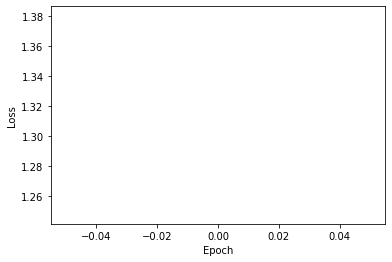

Epoch 2 Batch 0 Loss 0.8930
Epoch 2 Loss 0.6633
Time taken for 1 epoch 55.51381516456604 sec



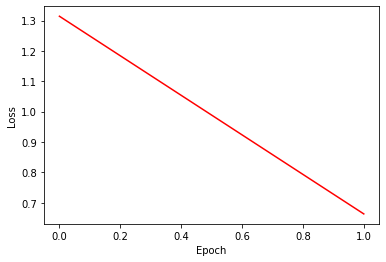

Epoch 3 Batch 0 Loss 0.5323
Epoch 3 Loss 0.5172
Time taken for 1 epoch 55.526495695114136 sec



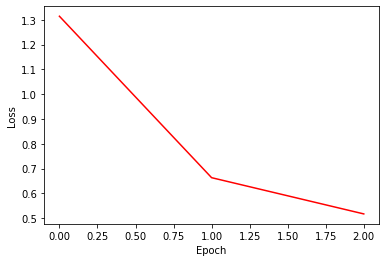

Epoch 4 Batch 0 Loss 0.4227
Epoch 4 Loss 0.4568
Time taken for 1 epoch 55.501237630844116 sec



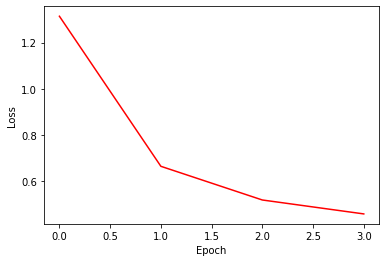

Epoch 5 Batch 0 Loss 0.4189
Epoch 5 Loss 0.4192
Time taken for 1 epoch 55.498939037323 sec



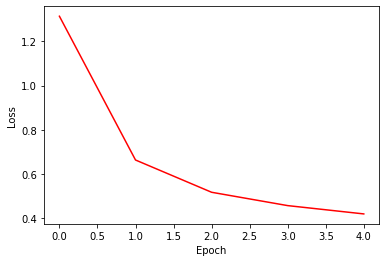

Epoch 6 Batch 0 Loss 0.3453
Epoch 6 Loss 0.3954
Time taken for 1 epoch 55.50361657142639 sec



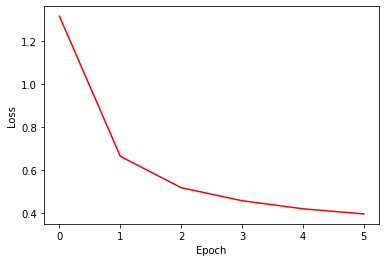

Epoch 7 Batch 0 Loss 0.3207
Epoch 7 Loss 0.3704
Time taken for 1 epoch 55.483341693878174 sec



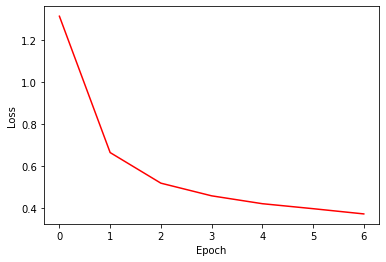

Epoch 8 Batch 0 Loss 0.3219
Epoch 8 Loss 0.3501
Time taken for 1 epoch 55.48669123649597 sec



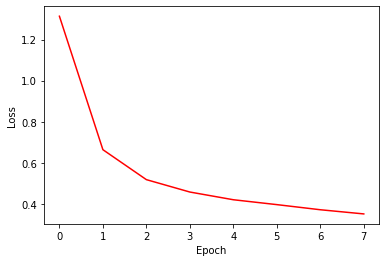

Epoch 9 Batch 0 Loss 0.2654
Epoch 9 Loss 0.3331
Time taken for 1 epoch 55.46540427207947 sec



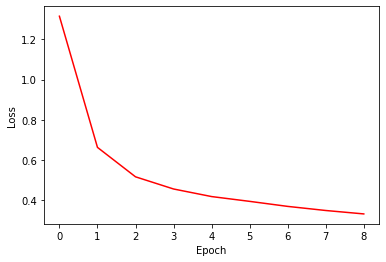

Epoch 10 Batch 0 Loss 0.2675
Epoch 10 Loss 0.3120
Time taken for 1 epoch 55.450236797332764 sec



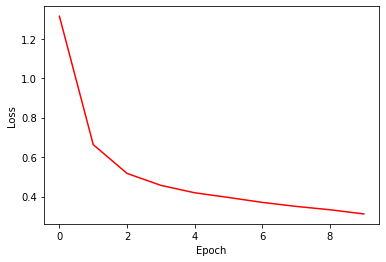

Epoch 11 Batch 0 Loss 0.3031
Epoch 11 Loss 0.2942
Time taken for 1 epoch 55.44049000740051 sec



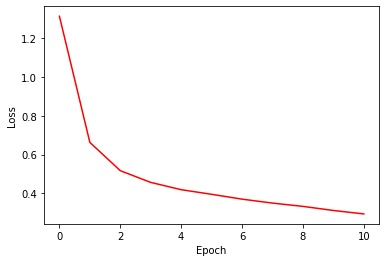

Epoch 12 Batch 0 Loss 0.2599
Epoch 12 Loss 0.2737
Time taken for 1 epoch 55.43822455406189 sec



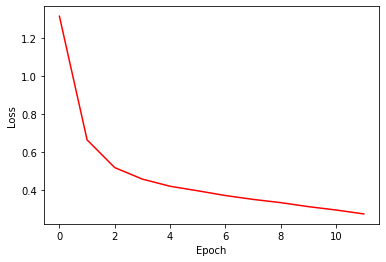

Epoch 13 Batch 0 Loss 0.2832
Epoch 13 Loss 0.2535
Time taken for 1 epoch 55.447468519210815 sec



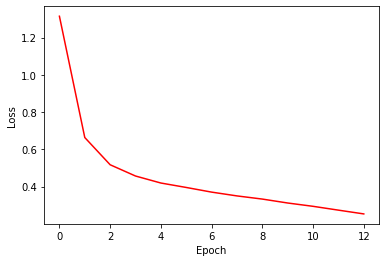

Epoch 14 Batch 0 Loss 0.2338
Epoch 14 Loss 0.2318
Time taken for 1 epoch 55.475085735321045 sec



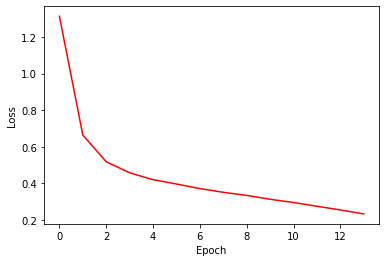

Epoch 15 Batch 0 Loss 0.1857
Epoch 15 Loss 0.2064
Time taken for 1 epoch 55.44837212562561 sec



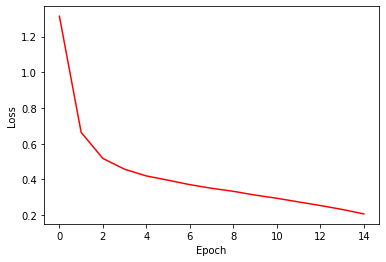

Epoch 16 Batch 0 Loss 0.1962
Epoch 16 Loss 0.1837
Time taken for 1 epoch 55.45496726036072 sec



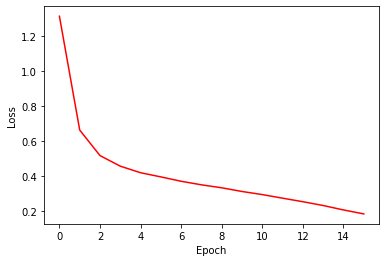

Epoch 17 Batch 0 Loss 0.1611
Epoch 17 Loss 0.1611
Time taken for 1 epoch 55.430734157562256 sec



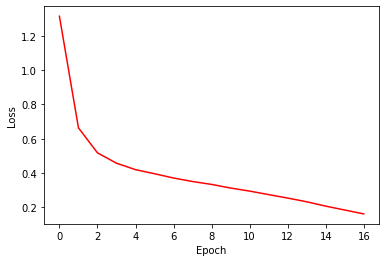

Epoch 18 Batch 0 Loss 0.1591
Epoch 18 Loss 0.1400
Time taken for 1 epoch 55.442792654037476 sec



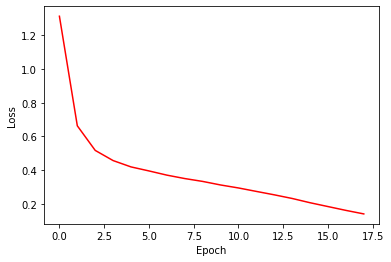

Epoch 19 Batch 0 Loss 0.1166
Epoch 19 Loss 0.1188
Time taken for 1 epoch 55.45505475997925 sec



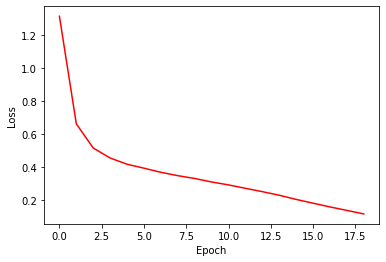

Epoch 20 Batch 0 Loss 0.0893
Epoch 20 Loss 0.0976
Time taken for 1 epoch 55.57246375083923 sec



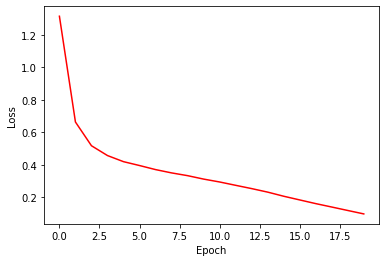

Epoch 21 Batch 0 Loss 0.0794
Epoch 21 Loss 0.0824
Time taken for 1 epoch 55.54940342903137 sec



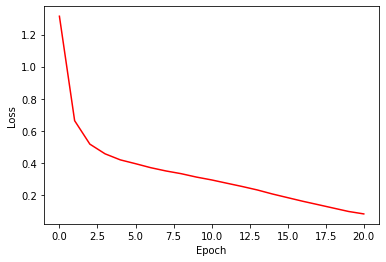

Epoch 22 Batch 0 Loss 0.0652
Epoch 22 Loss 0.0757
Time taken for 1 epoch 55.5620481967926 sec



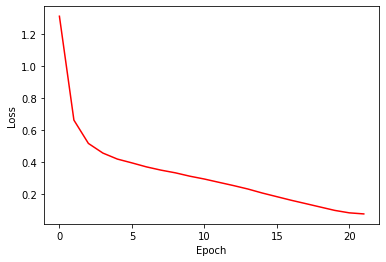

Epoch 23 Batch 0 Loss 0.0562
Epoch 23 Loss 0.0649
Time taken for 1 epoch 55.545435667037964 sec



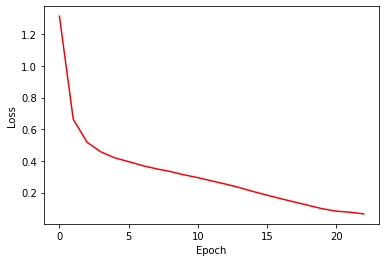

Epoch 24 Batch 0 Loss 0.0396
Epoch 24 Loss 0.0544
Time taken for 1 epoch 55.52621030807495 sec



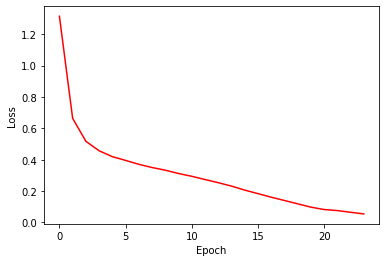

Epoch 25 Batch 0 Loss 0.0347
Epoch 25 Loss 0.0466
Time taken for 1 epoch 61.520344257354736 sec



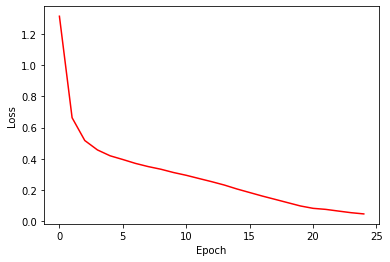

Validation
BLUE Scores=go to https://www.letsmt.eu/Bleu.aspx and provide your *.txt files under gdrive/My Drive/Colab Notebooks/ML/Task 2//training_checkpoints
RECALL@1=0.6212121212121212
Mean Reciprocal Rank=0.7675439915023242
Testing
BLUE Scores=go to https://www.letsmt.eu/Bleu.aspx and provide your *.txt files under gdrive/My Drive/Colab Notebooks/ML/Task 2//training_checkpoints
RECALL@1=0.49183673469387756
Mean Reciprocal Rank=0.671121639131843
Execution time=7094.510186433792 secs.


In [16]:
#########################################
# MAIN PROGRAM
#########################################

"""
Lines have been commented out above so that the validation and test scores can be seen. 
If the attention plots are needed just uncomment the appropriate lines.
All hyperparams have been kept the same though all models.
"""
# Params set from baseline
start_exec_time = time.time()
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
#Vocab setting
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
#Read in data
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
#batch the data
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
#Create encoder with hidden state
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
#Bidirectional so need forward and back
sample_output, forward_h, forward_c, backward_h, backward_c = encoder(example_input_batch, sample_hidden)

#Concat the forward and backward pass as the sample hidden to decoder
sample_hidden = tf.keras.layers.Concatenate()([forward_h, backward_h])
#Create decoder
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
#Get output from decoder, pass in initial state of encoder
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output, initial_state = [forward_h, forward_c, backward_h, backward_c])


#Save checkpoints
checkpoint_dir = root_path + '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

#Same epochs for all
epoch = 25
for filename in os.listdir(checkpoint_dir):
  print("Erasing file " +str(filename))
  os.remove(checkpoint_dir + "/" + filename)
print("Training")
train_model(epoch)
print("Validation")
evaluate_model(root_path + path_to_data_val, checkpoint_dir)
print("Testing")
evaluate_model(root_path + path_to_data_test, checkpoint_dir)

exec_time = time.time() - start_exec_time
print("Execution time="+str(exec_time)+" secs.")